In [1]:
%load_ext autoreload
%autoreload 2
import jax
from jax import random
from envs.rodent import RodentTracking
from envs.humanoid import HumanoidTracking
from envs.ant import AntTracking
import numpy as np
import mediapy as media
import jax.numpy as jp
import mujoco

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='mujoco')
warnings.filterwarnings('ignore', category=DeprecationWarning, module='brax')

#### Ant env

In [4]:
params = {
    "solver": "newton",
    "iterations": 1,
    "ls_iterations": 4,
    "clip_path": "ant_traj.p",
}

In [5]:
ant = AntTracking(params)

In [6]:
ant.sys.nbody

10

#### Humanoid env

In [2]:
params = {
    "solver": "cg",
    "iterations": 6,
    "ls_iterations": 6,
    "clip_path": "data/humanoid_traj.p",
}

In [3]:
humanoid = HumanoidTracking(params)

In [4]:
obj_id = mujoco.mj_name2id(humanoid.sys.mj_model, mujoco.mju_str2Type("body"), "head")
obj_id

2

In [5]:
state = humanoid.reset(jax.random.PRNGKey(0))

In [6]:
state.pipeline_state.xpos[2]

Array([-5.4630125e-04,  7.6789209e-03,  1.4727731e+00], dtype=float32)

In [7]:
state.obs.shape

(82,)

In [8]:
state.pipeline_state.qpos.shape[0] + \
state.pipeline_state.qvel.shape[0] + \
state.pipeline_state.qfrc_actuator.shape[0]

82

In [9]:
key = random.PRNGKey(0)
humanoid_step = jax.jit(humanoid.step)
humanoid_reset = jax.jit(humanoid.reset)
humanoid_reset_to_frame = jax.jit(humanoid.reset_to_frame)

In [10]:
next = humanoid_reset(key)
print("starting rollout")
mu = 0
sigma = 0.1
rollout = []
for _ in range(250):
    _, key = jax.random.split(key)
    next = humanoid_step(
        next, mu + sigma * random.normal(key, shape=(humanoid.sys.nu,))
    )
    rollout.append(next)

starting rollout


In [11]:
import imageio

ref_traj = humanoid._ref_traj

qposes_ref = []
for i in range(250):
    qpos_ref = jp.hstack(
        [
            ref_traj.position[i, :],
            ref_traj.quaternion[i, :],
            ref_traj.joints[i, :],
        ]
    )
    qposes_ref.append(qpos_ref)

qposes_rollout = [] 
for i in rollout:
    qpos = i.pipeline_state.qpos
    qposes_rollout.append(qpos)

from dm_control.mujoco import wrapper
from dm_control.mujoco.wrapper.mjbindings import enums

scene_option = wrapper.MjvOption()
# scene_option.geomgroup[1] = 0
scene_option.geomgroup[2] = 1
# scene_option.geomgroup[3] = 0
# scene_option.sitegroup[0] = 0
# scene_option.sitegroup[1] = 0
scene_option.sitegroup[2] = 1

scene_option.sitegroup[3] = 1
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[enums.mjtVisFlag.mjVIS_LIGHT] = False
scene_option.flags[enums.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[enums.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[enums.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[enums.mjtRndFlag.mjRND_FOG] = False

"""Render the walker with the reference expert demonstration trajectory"""
mj_model = mujoco.MjModel.from_xml_path("./assets/humanoid_pair.xml")
mj_model.opt.solver = {
    "cg": mujoco.mjtSolver.mjSOL_CG,
    "newton": mujoco.mjtSolver.mjSOL_NEWTON,
}["cg"]
mj_model.opt.iterations = 6
mj_model.opt.ls_iterations = 6
mj_model.opt.jacobian = 0  # dense
mj_data = mujoco.MjData(mj_model)
# mj_data.xpos = _UPRIGHT_POS
# mj_data.xquat = _UPRIGHT_QUAT
mujoco.mj_kinematics(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model, height=512, width=512)
frames = []
# render while stepping using mujoco
with imageio.get_writer("render.mp4", fps=30) as video:
    for i, (qpos1, qpos2) in enumerate(zip(qposes_ref, qposes_rollout)):
        if i % 100 == 0:
            print(f"rendering frame {i}")

        # Set keypoints
        # physics, mj_model = ctrl.set_keypoint_sites(physics, keypoint_sites, kps)
        mj_data.qpos = np.append(qpos1, qpos2)
        mujoco.mj_forward(mj_model, mj_data)

        renderer.update_scene(
            mj_data, camera=0, scene_option=scene_option
        )
        pixels = renderer.render()
        video.append_data(pixels)
        frames.append(pixels)

rendering frame 0


/home/talmolab/anaconda3/envs/vnl/lib/python3.11/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(


rendering frame 100
rendering frame 200


In [12]:
import mediapy as media
import os

os.environ["MUJOCO_GL"] = "glfw"
rollout_data = [s.pipeline_state for s in rollout]

video = humanoid.render(rollout_data, camera='side', height=500, width=500)

media.show_video(video, fps=1.0 / humanoid.dt)

In [13]:
import matplotlib.pyplot as plt

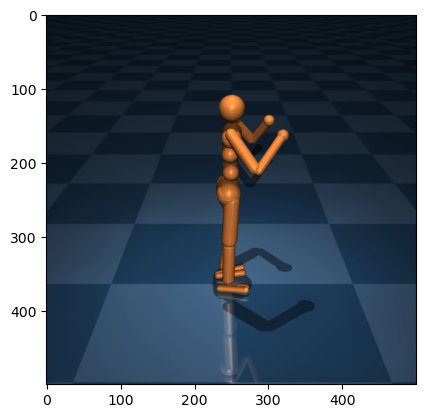

In [14]:
img = humanoid.render(rollout_data, camera="side", height=500, width=500)
plt.imshow(img[0])

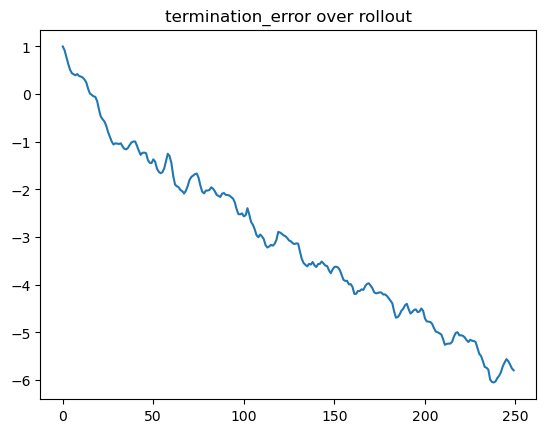

In [15]:
from matplotlib import pyplot as plt
# plot termination error over time:
errors = [s.metrics['termination_error'] for s in rollout]
plt.title("termination_error over rollout")
plt.plot(errors)

## Testing the Humanoid Environment's Reward Function

#### Rodent env

In [56]:
params = {
    "scale_factor": 0.9,
    "solver": "cg",
    "iterations": 6,
    "ls_iterations": 6,
    "xml_path": "assets/rodent.xml",
    "clip_path": "transform_snips_250_clip_750.p",
    "walker_body_names": ['torso', 'pelvis', 'upper_leg_L', 'lower_leg_L', 'foot_L', 'upper_leg_R', 'lower_leg_R', 'foot_R', 'skull', 'jaw', 'scapula_L', 'upper_arm_L', 'lower_arm_L', 'finger_L', 'scapula_R', 'upper_arm_R', 'lower_arm_R', 'finger_R'],
    "end_eff_names": [
        "foot_L",
        "foot_R",
        "hand_L",
        "hand_R",
    ],
}

# Creating env objects

In [57]:
env = RodentSingleClipTrack(params)

In [58]:
key = random.PRNGKey(0)
jit_step = jax.jit(env.step)
jit_reset = jax.jit(env.reset)

In [59]:
key, subkey = jax.random.split(key) 
state = env.reset(subkey)
env._calculate_termination(state)

[-4.7722409e-04  2.8163995e-04 -8.4090367e-04  6.0226081e-04
  1.0404602e-03  1.6914152e-03  1.0947160e-03 -1.0179050e-04
  1.6476601e-04 -2.8294667e-03  8.8693126e-04 -5.1368203e-04
  5.9041288e-04 -8.8200113e-04  1.2494448e-03  2.5188155e-04
  9.9422257e-05 -1.2817878e-03 -6.5700745e-04  4.4882563e-05
 -5.1222701e-04  5.1518338e-04 -6.2167970e-04 -1.9824257e-04
 -9.5051968e-05  1.1424529e-03 -3.0697577e-04  4.8699298e-05
  3.5624456e-04  5.6182063e-04  1.5389369e-03  3.2522317e-04
  1.3367548e-03  9.8856224e-04  1.4204493e-03  5.4973963e-04
 -1.5584289e-04 -8.5814483e-04  2.5936909e-04 -1.1357025e-03
 -8.4086983e-05 -4.0105707e-04  1.7144010e-04  1.3368111e-03
  1.0823595e-04 -3.1889335e-04  1.1413924e-04 -1.6834441e-04
 -2.3103834e-03  1.6328682e-04  1.0740045e-03  1.1257745e-03
 -1.2201234e-03  1.2311945e-03  5.8456970e-04 -1.0888724e-03
 -6.0622208e-04  1.0449032e-03 -1.3182943e-03 -1.8421815e-03
  2.5926733e-03  4.1853130e-04  6.2172447e-04 -1.9652639e-03
 -4.5445902e-04  1.37276

Array(0.88605523, dtype=float32)

Array(-0.5230558, dtype=float32)

In [ ]:
env._ref_traj.body_positions.shape

(250, 18, 3)

In [ ]:
next = jit_reset(key)
print("starting rollout")
mu = 0
sigma = .3
rollout = []
for _ in range(250):
    _, key = random.split(key)
    next = jit_step(next, mu + sigma * random.normal(key, shape=(env.sys.nu,)))
    rollout.append(next)

starting rollout


In [ ]:
jp.isclose(state.obs, 0)

Array([False, False, False, ..., False, False, False], dtype=bool)

In [ ]:
jp.isclose(state.obs, 0).sum()/state.obs.shape[0]

Array(0.17094861, dtype=float32)

# Stepping Env: Test step_fn, reward_fn, & termination_fn
`step_fn`, which calls `reward_fn` & `termination_fn` is only used when actually making action, not when setting up environment and state object

In [ ]:
# next = jit_reset(key)
# print("starting rollout")
# mu = 0
# sigma = .1
# rollout = []
# for _ in range(500):
#     next = jit_step(next, mu + sigma * random.normal(key, shape=(env.sys.nu,)))
#     rollout.append(next)

In [ ]:
# import mediapy as media
# import os

# os.environ["MUJOCO_GL"] = "glfw"
# rollout_data = [s.pipeline_state for s in rollout]

video = env.render(rollout_data, camera='side_alt', height=512, width=512)
media.show_video(video, fps=50)

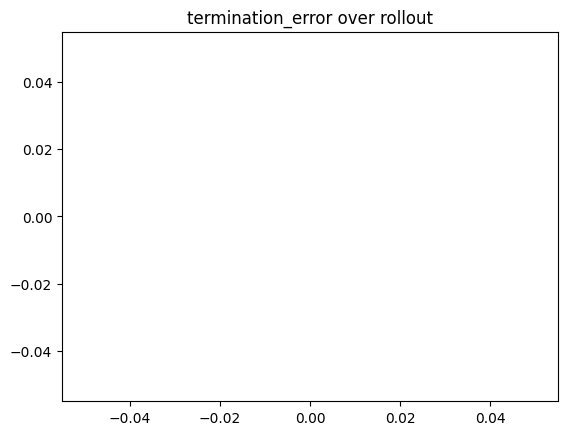

In [ ]:
from matplotlib import pyplot as plt
# plot termination error over time:
errors = [s.metrics['termination_error'] for s in rollout]
plt.title("termination_error over rollout")
plt.plot(errors)

In [ ]:
jax.tree_util.tree_map(
    lambda x: print(x.shape),
    env._ref_traj,
)